In [15]:
using PyPlot, StatsBase, Printf, DelimitedFiles, Combinatorics;
using Revise;
using MDToolbox;
PyPlot.plt.style.use("seaborn-colorblind");
ENV["COLUMNS"] = 110; #display width for MDToolbox

### Potential energy function

In [16]:
V(x; k=1.0) = sum(- (1.0 / 2.0) .* k .* x.^2 .+ (1.0 ./ 4.0) .* k .* x.^4)
V([0.0], k=1.0)

0.0

### Proposal distribution

In [17]:
proposal_fun(x) = x .+ (rand(Float64, size(x)) .* 2.0 .- 1.0);
proposal_fun([0.0])

1-element Array{Float64,1}:
 -0.1307280716334951

### set permutation

In [18]:
perm=collect(permutations(1:4))

24-element Array{Array{Int64,1},1}:
 [1, 2, 3, 4]
 [1, 2, 4, 3]
 [1, 3, 2, 4]
 [1, 3, 4, 2]
 [1, 4, 2, 3]
 [1, 4, 3, 2]
 [2, 1, 3, 4]
 [2, 1, 4, 3]
 [2, 3, 1, 4]
 [2, 3, 4, 1]
 [2, 4, 1, 3]
 [2, 4, 3, 1]
 [3, 1, 2, 4]
 [3, 1, 4, 2]
 [3, 2, 1, 4]
 [3, 2, 4, 1]
 [3, 4, 1, 2]
 [3, 4, 2, 1]
 [4, 1, 2, 3]
 [4, 1, 3, 2]
 [4, 2, 1, 3]
 [4, 2, 3, 1]
 [4, 3, 1, 2]
 [4, 3, 2, 1]

In [19]:
function output_weight(io::IOStream, x::Vector{Float64}, temperature::Float64)    
    @printf(io, "%f", temperature)
    for i in length(x)
        @printf(io, " %f", x[i])
    end
    @printf(io, "\n")
end

output_weight (generic function with 1 method)

### define functions for infinite swapping

温度Tにおけるxの分布は、以下のπに比例する

\begin{align}
\pi({\bf x},T) = e^{-V({\bf x})/T}
\end{align}

In [20]:
pai(x, T) = exp.(-V(x) ./ T)

pai (generic function with 1 method)

ρ_n(X)はある温度における期待値を求める際の「重み」のようなもの

\begin{align}
\rho_n({\bf X}) = \frac{P_n \left[ \pi({\bf x}_1, T_1) \pi({\bf x}_2, T_2) \ldots \pi({\bf x}_N, T_N) \right]}{\mu({\bf X})}
\end{align}

ここでμ(X)はsymmetrized distribution

\begin{align}
\mu({\bf X})  = \sum_{n=1}^{N!} P_n \left[ \pi({\bf x}_1, T_1) \pi({\bf x}_2, T_2) \ldots \pi({\bf x}_N, T_N) \right]
\end{align}


物理量A(x)の温度T_kにおける期待値は以下のように求められる

\begin{align}
< A >_k = \frac{\int \mu({\bf X}) \left[ \sum_{n=1}^{N!}\rho_n({\bf X}) A({\bf x}_{indx(n,k)}) \right] d{\bf X}}{\int \mu({\bf X}) d{\bf X}}
\end{align}

これを時間平均でもとめると
\begin{align}
< A >_k = \frac{1}{M} \sum_{m=0}^{M} \sum_{n=1}^{N!}\rho_n({\bf X}_m) A({\bf x}_{indx(n,k),m})
\end{align}

In [21]:
function calc_rou!(rou, x, T, Perm)
    nreplica = length(x)
    nperm = length(rou)
    mu = 0.0
    for n = 1:nperm
        rou[n] = 0.0
        rou[n] = pai(x[1], T[Perm[n][1]])
        for i = 2:nreplica
            rou[n] *= pai(x[i], T[Perm[n][i]])
        end
        mu += rou[n]
    end
    rou .= rou./mu
    return rou
end

calc_rou! (generic function with 1 method)

In [22]:
function select_n(rou)
    rou_cumsum = cumsum(rou)
    r = rand()
    n = sum(r .> rou_cumsum ) + 1
    return n
end

select_n (generic function with 1 method)

### Infinite swap MCMC

In [27]:
function flush_weight(io::IOStream, m, rou, Perm)
    nperm = length(rou)
    nreplica = length(Perm[1])
    weight = zeros(Float64, nreplica)
    
    for n = 1:nperm
        id_replica = Perm[n][m]
        weight[id_replica] += rou[n]
    end
    
    for i = 1:nreplica
        @printf(io, "%f ", weight[i])
    end
    @printf(io, "\n")
end

flush_weight (generic function with 1 method)

In [28]:
nreplica = 4
temperature_replica = [0.01, 0.10, 0.30, 0.40];
nstep = 2000;
nexchange = 20;
Perm=collect(permutations(1:nreplica))
nperm=factorial(nreplica)

x_replica = []
for i = 1:nreplica
    x = [0.0]
    push!(x_replica, x)
end

io_replica = []
for i = 1:nreplica
    filename = "replica$(i).dat"
    io = open(filename, "w")
    push!(io_replica, io)
end

io_weight=[]
for m = 1:nreplica
    filename = "weight$(m).dat"
    io = open(filename, "w")
    push!(io_weight, io)
end

In [29]:
rou=ones(Float64, nperm)
calc_rou!(rou, x_replica, temperature_replica, Perm)
   
icount = 0
for istep = 1:nstep
    n = select_n(rou)  

    for i = 1:nreplica
        x_replica[i] = propagate_mcmc(y -> V(y), proposal_fun, x_replica[i], temperature_replica[Perm[n][i]], nstep=1, io=io_replica[i]);       
    end
    calc_rou!(rou, x_replica, temperature_replica, Perm)

    for m = 1:nreplica
        flush_weight(io_weight[m], m, rou, Perm)
    end
end

In [30]:
for i = 1:nreplica
    close(io_replica[i])
    close(io_weight[i])
end

### Trajectory analysis

In [32]:
traj_replica = []
temp_replica = []

for i = 1:nreplica
    filename = "replica$(i).dat"
    data = readdlm(filename);
    push!(temp_replica, data[:, 1])
    push!(traj_replica, data[:, 2])
end

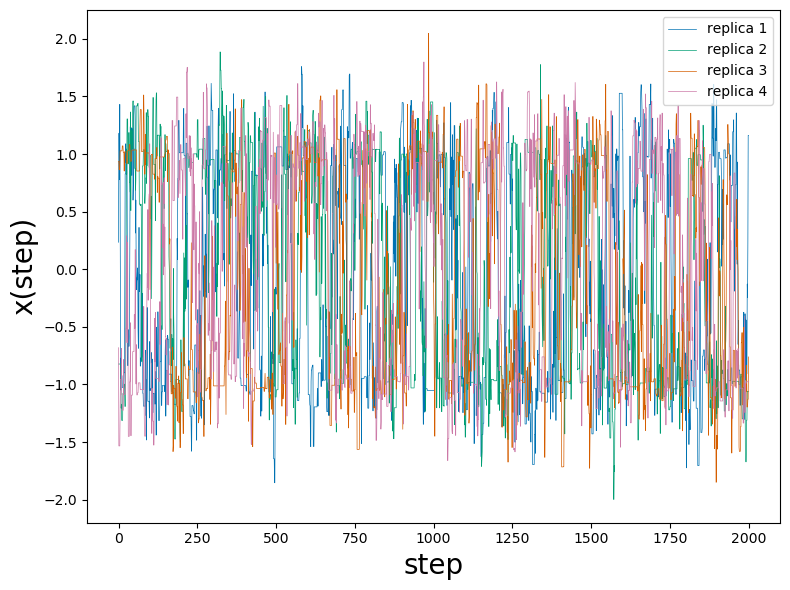

In [33]:
fig, ax = subplots(figsize=(8, 6))
for i = 1:nreplica
    ax.plot(traj_replica[i], linewidth=0.5)   
end
xlabel("step",fontsize=20)
ylabel("x(step)",fontsize=20)

ax.legend(["replica 1", "replica 2", "replica 3", "replica 4"])
tight_layout()

In [34]:
filename = "weight1.dat"
weight_replica = readdlm(filename);

In [41]:
traj = traj_replica[1]
weight = weight_replica[:, 1]

for i = 2:nreplica
    traj = [traj; traj_replica[i]]
    weight = [weight; weight_replica[:, i]]
end

In [45]:
x_grid = range(-1.3, 1.3, length=100);
pmf_theory = V.(x_grid, k=1) ./ temperature_replica[1]
pmf_theory .= pmf_theory .- minimum(pmf_theory);

In [46]:
pmf_observed, _ = getpmf(traj, weight= weight, grid_x = collect(x_grid), bandwidth=0.05);

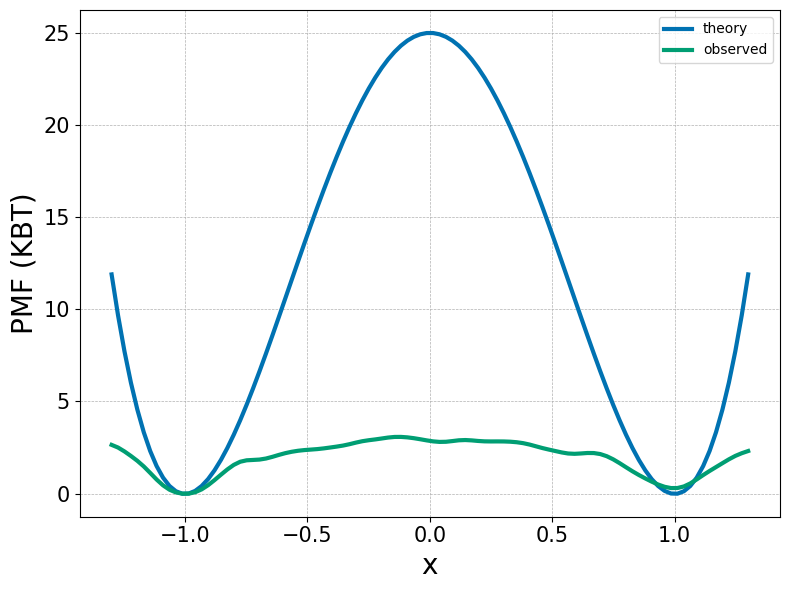

In [47]:
fig, ax = subplots(figsize=(8, 6))
ax.plot(x_grid, pmf_theory, linewidth=3)
xlabel("x",fontsize=20)
ylabel("PMF (KBT)",fontsize=20)

ax.plot(x_grid, pmf_observed, linewidth=3)

ax.legend(["theory", "observed"])

ax.xaxis.set_tick_params(which="major",labelsize=15)
ax.yaxis.set_tick_params(which="major",labelsize=15)
ax.grid(linestyle="--", linewidth=0.5)
tight_layout()
savefig("mcmc_replica_exchange.png", dpi=350)